In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 835831450836984198, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8435218125357656660
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
import os

os.chdir('/gdrive/My Drive/Calisma_Ortami')

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [6]:
root = '/gdrive/My Drive/Calisma_Ortami/'

data = pd.read_csv(root + 'data16/fer2013.csv')

#Veri Önişleme

##Train Verisi önişleme

In [7]:
np.unique(data["Usage"].values.ravel())

train_data = data [data.Usage == "Training"]#sadece eğitim örneklerini train_data değişkenine aldık
#eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
x_train = train_pixels.values
x_train = x_train.astype(np.float)

In [8]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)

##Test Verisi Ön işleme


In [9]:
np.unique(data["Usage"].values.ravel())

test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
x_test = test_pixels.values
x_test = x_test.astype(np.float)

In [10]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

#Derin öğrenme modeli


In [24]:
model = Sequential()

### 1.KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 2. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25)) 

### 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.25))

### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
#model özetini görselleştirelim

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_19 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
activation_22 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_20 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_23 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 64)       

In [25]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)

#En Başarılı Ağırlıkları Kaydetme

In [26]:
checkpointer = ModelCheckpoint(filepath=root + 'data16/face_model_yeni.h5', verbose=1, save_best_only=True)

epochs = 15
batchSize = 100

# modeli çalıştır

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)
                
# save model to json
model_json = model.to_json()
with open(root + 'data16/face_model.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/15
288/288 - 10s - loss: 1.6402 - accuracy: 0.3691 - val_loss: 1.4168 - val_accuracy: 0.4645

Epoch 00001: val_loss improved from inf to 1.41676, saving model to /gdrive/My Drive/Calisma_Ortami/data16/face_model_yeni.h5
Epoch 2/15
288/288 - 8s - loss: 1.3593 - accuracy: 0.4770 - val_loss: 1.2979 - val_accuracy: 0.5001

Epoch 00002: val_loss improved from 1.41676 to 1.29789, saving model to /gdrive/My Drive/Calisma_Ortami/data16/face_model_yeni.h5
Epoch 3/15
288/288 - 8s - loss: 1.2448 - accuracy: 0.5266 - val_loss: 1.2479 - val_accuracy: 0.5141

Epoch 00003: val_loss improved from 1.29789 to 1.24794, saving model to /gdrive/My Drive/Calisma_Ortami/data16/face_model_yeni.h5
Epoch 4/15
288/288 - 8s - loss: 1.1814 - accuracy: 0.5502 - val_loss: 1.1901 - val_accuracy: 0.5400

Epoch 00004: val_loss improved from 1.24794 to 1.19010, saving model to /gdrive/My Drive/Calisma_Ortami/data16/face_model_yeni.h5
Epoch 5/15
288/288 - 8s - loss: 1.1316 - accuracy: 0.5705 - val_loss: 1.1573 - 

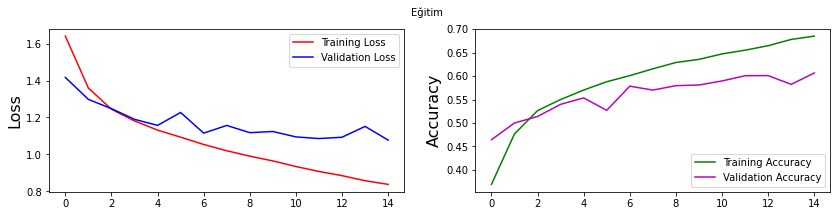

In [27]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)

plt.ylabel('loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

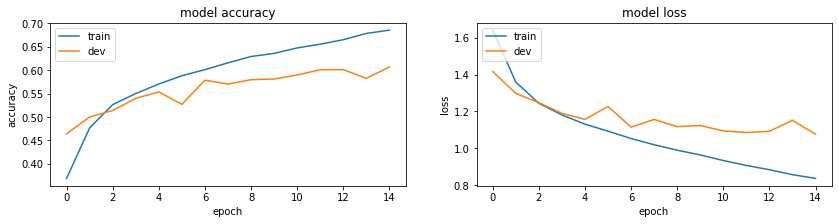

In [34]:
# list all data in history
plt.figure(figsize=(14,3))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()